In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='0b9becfe-d174-4bec-baaf-c7e7fe1b27ab', project_access_token='p-2+TOLfqNSexX1UJg9hxiFMBw==;eixmY9/4DMVcMaB96BxlrQ==:zqIZbFh8THaYsqOl1YPDa83QhqxraD0QhLGIk3MuTQCmb1M/2CcTnyUoW0MARGqgy8c08OdI63KQ4czLR8QDwT5h91+wJKc1JA==')
pc = project.project_context

from ibm_watson_studio_lib import access_project_or_space
wslib = access_project_or_space({'token':'p-2+TOLfqNSexX1UJg9hxiFMBw==;eixmY9/4DMVcMaB96BxlrQ==:zqIZbFh8THaYsqOl1YPDa83QhqxraD0QhLGIk3MuTQCmb1M/2CcTnyUoW0MARGqgy8c08OdI63KQ4czLR8QDwT5h91+wJKc1JA=='})

deployment_space_id = 'bb22714b-5c39-4fde-ad4b-5fb59d1f22f3'
# cpd_base_url = 'https://dataplatform.cloud.ibm.com'

# Set up Project Token and API Key

In [2]:
project.get_name()


'MLOps Monitoring Fraud Detection'

In [3]:
# ibmcloud_api_key = 'Apn4to2Oga8LvhspP3ORbatlMqW5EsdUEU-Aorv2jCK8'
ibmcloud_api_key = 'y8Bqy4ldbJYT1o4UEY0MhA9tD7cTPcbIJO3gV-Ekb5Nk'

# Set up

In [4]:
import os
import datetime
import base64
import json
import requests
import time
import numpy as np

from ibm_watson_machine_learning import APIClient
import pandas as pd
import ibm_boto3
from ibm_botocore.client import Config

import ibm_db, ibm_db_dbi as dbi

# COS Credentials (Cloud Object Storage)

In [5]:
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator,BearerTokenAuthenticator

from ibm_watson_openscale import *
from ibm_watson_openscale.supporting_classes.enums import *
from ibm_watson_openscale.supporting_classes import *

authenticator = IAMAuthenticator(apikey=ibmcloud_api_key)
wos_client = APIClient(authenticator=authenticator)

cos_credentials = {
    'apikey': 'bp-_9Nppek7J6Jjp7MlhgFyJNNz74r4vvxuWMh9zL3aj',
    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
#     'cos_hmac_keys': {
#         'access_key_id': 'your-access-key-id',
#         'secret_access_key': 'your-secret-access-key'
#     },
    'service_instance_id': 'crn:v1:bluemix:public:iam-identity::a/59f2c5bf57f643d88258500aed31b739::serviceid:ServiceId-56692de6-1039-4978-92dd-074515217ca7',
    'endpoints': 'https://control.cloud-object-storage.cloud.ibm.com/v2/endpoints',
    'ibm_auth_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
    'bucket': 'mlopsmonitoringfrauddetection-donotdelete-pr-d5rj3reapahkjf'
}

cos_client = ibm_boto3.client('s3',
    ibm_api_key_id=cos_credentials['apikey'],
    ibm_service_instance_id=cos_credentials['service_instance_id'],
    ibm_auth_endpoint=cos_credentials['ibm_auth_endpoint'],
    config=Config(signature_version='oauth'),
    endpoint_url=cos_credentials['endpoints']
)

# # Set the authenticator for the WML client
# wml_client = APIClient(wml_credentials)

# Load datasets

In [6]:
# data = pd.read_csv('./creditcard_2023.csv')

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(
    service_name='s3',
    ibm_api_key_id='kmYxYjVjqDeXgwwK46vUveoIQydIum_5_1CDN3gzJuJ9',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us-south.cloud-object-storage.appdomain.cloud'
)

bucket = 'mlopsmonitoringfrauddetection-donotdelete-pr-d5rj3reapahkjf'

# List of object keys for the datasets you want to load
object_keys = [
    'half1_creditcard_2023.csv',
    'half2_shard_creditcard_2023_1.csv',
    'half2_shard_creditcard_2023_2.csv',
    'half2_shard_creditcard_2023_3.csv',
    'half2_shard_creditcard_2023_4.csv',
    'half2_shard_creditcard_2023_5.csv'
]

all_datasets = [cos_client.get_object(Bucket=bucket,Key=object_key)['Body'] for object_key in object_keys]
initial_dataset = pd.read_csv(all_datasets[0])
sharded_datasets = [pd.read_csv(x) for x in all_datasets[1:]]

# # @hidden_cell
# # The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# # You might want to remove those credentials before you share the notebook.
# cos_client = ibm_boto3.client(service_name='s3',
#     ibm_api_key_id='kmYxYjVjqDeXgwwK46vUveoIQydIum_5_1CDN3gzJuJ9',
#     ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
#     config=Config(signature_version='oauth'),
#     endpoint_url='https://s3.private.us-south.cloud-object-storage.appdomain.cloud')

# bucket = 'mlopsmonitoringfrauddetection-donotdelete-pr-d5rj3reapahkjf'
# object_key = 'creditcard_2023.csv'

# body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# # add missing __iter__ method, so pandas accepts body as file-like object
# if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# master_dataset = pd.read_csv(body)
# master_dataset.head()

In [7]:
# Specify a name for the space being created, the saved model and the model deployment
space_name = 'DeploymentSpace'
model_name_prefix = 'InitialModel_'
deployment_name = 'credit-card-transaction-fraud-detection-deployment'

# Function to run predictions on shards

In [8]:
# Function to run predictions on shards (after initial model deployment)
def run_predictions_on_new_dataset(df_data_1, deployment_endpoint):
    print("attempting login...")
    API_KEY = ibmcloud_api_key
    token_response = requests.post(
        'https://iam.cloud.ibm.com/identity/token',
        data= {
            "apikey": API_KEY,
            "grant_type": 'urn:ibm:params:oauth:grant-type:apikey'
        }
    )

    print("login successful !!")

    # print(token_response.json())

    mltoken = token_response.json()["access_token"]

    header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken}

    # Initialize arrays for input fields and values to be scored
    array_of_input_fields = []
    array_of_values_to_be_scored = []

    # # Path to the directory containing CSV files
    # csv_file = r'verifiedTransactions_CbBnOijaKA.csv'

    # # for csv_file in os.listdir(csv_directory):
    # if csv_file.endswith('.csv'):
    # #     csv_path = os.path.join(csv_directory, csv_file)

    #     print("filename: " + csv_file)

    # Read the CSV file
    df_scoring = df_data_1

    df_scoring = df_scoring.drop(columns='Class')

    # Extract column headings
    array_of_input_fields = list(df_scoring.columns)

    # Extract rows as a list of lists
    rows_data = df_scoring.values.tolist()

    # Add rows data to the array of values to be scored
    array_of_values_to_be_scored = rows_data

    print(array_of_input_fields)

    print(len(array_of_input_fields))
    print(str(len(array_of_values_to_be_scored)) + " x " + str(len(array_of_values_to_be_scored[0])))

    # Prepare payload for scoring
    payload_scoring = {"input_data": [{"fields": array_of_input_fields, "values": array_of_values_to_be_scored}]}

    #     with open(csv_directory + '/json_' + csv_file[:-4] + '.json', "w") as fd:
    #         json.dump(payload_scoring, fd)

    # Make scoring request
    # response_scoring = requests.get(deployment_endpoint) #, json=payload_scoring, headers=header, verify=True)

    try:
        response_scoring = requests.post(deployment_endpoint, json=payload_scoring, headers={'Authorization': 'Bearer ' + mltoken})

        # Check if the request was successful (HTTP status code 200)
        if response_scoring.status_code == 200:
            scoring_response = response_scoring.json()
            predictions = scoring_response['predictions']

            # Extract the maximum probability for each prediction
            max_probabilities = [max(pred['values'][0][1]) for pred in predictions]

            # Calculate the average of the maximum probabilities
            average_max_probability = np.mean(max_probabilities)

    #         print("Scoring response:")
    #         print(scoring_response)
            return (average_max_probability)
    
    except Exception as e:
        print("Scoring request failed with Error: ", e)
        return 0



# Monitoring - Checking the accuracy of each shard

In [9]:
average_accuracy_threshold = 0.99

prediction_average_accuracies = []

last_shard_that_ran = -1

for i in range(len(sharded_datasets)):
    deployment_endpoint = 'https://private.us-south.ml.cloud.ibm.com/ml/v4/deployments/2ee8620d-9395-481a-a284-723bea38efae/predictions?version=2021-05-01'
    print("processing shard {}".format(i + 1))
    last_shard_that_ran += 1
    prediction_average_accuracy = run_predictions_on_new_dataset(sharded_datasets[i], deployment_endpoint)
    if prediction_average_accuracy >= average_accuracy_threshold:
        prediction_average_accuracies.append(prediction_average_accuracy)
    else:
        print("Need to combine base dataset and shards upto {}".format(i + 1))
        prediction_average_accuracies.append(prediction_average_accuracy)
        break

processing shard 1
attempting login...
login successful !!
['id', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
30
56863 x 30
processing shard 2
attempting login...
login successful !!
['id', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
30
56863 x 30
processing shard 3
attempting login...
login successful !!
['id', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
30
56863 x 30
processing shard 4
attempting login...
login successful !!
['id', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 

# Analyzing - Whether or not to retrain model

In [10]:
if last_shard_that_ran == len(sharded_datasets) - 1:
    print("Average accuracy is above threshold, no need to retrain !!")
else:
    print("Average accuracy dropped to {:.6%}, which is less than the threshold {:.6%}. NEED TO RETRAIN THE MODEL !!".format(prediction_average_accuracies[-1], average_accuracy_threshold))

Average accuracy dropped to 54.340196%, which is less than the threshold 99.000000%. NEED TO RETRAIN THE MODEL !!


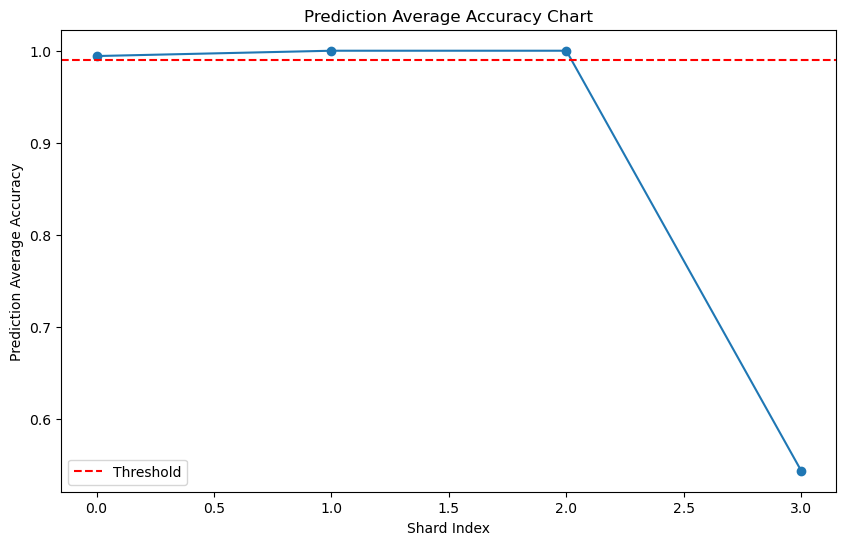

In [11]:
import matplotlib.pyplot as plt

# Assuming prediction_average_accuracies is a list containing accuracy values
# and last_shard_that_ran, average_accuracy_threshold are defined

# Plotting the prediction average accuracy chart
plt.figure(figsize=(10, 6))
plt.plot(range(last_shard_that_ran + 1), prediction_average_accuracies, marker='o', linestyle='-')
plt.axhline(y=average_accuracy_threshold, color='r', linestyle='--', label='Threshold')

# Adding labels and title
plt.xlabel('Shard Index')
plt.ylabel('Prediction Average Accuracy')
plt.title('Prediction Average Accuracy Chart')

# Adding legend
plt.legend()

# Display the chart
plt.show()

# Planning - Merging Datasets and uploading to Project Assets

In [12]:
combined_datasets = [initial_dataset] + sharded_datasets[:last_shard_that_ran]

new_combined_dataset = pd.concat(combined_datasets, ignore_index=True)

# Save the combined dataset back to IBM Cloud Object Storage
combined_object_key = 'updated_creditcard_2023.csv'
combined_csv = new_combined_dataset.to_csv(index=False)

# cos_client.put_object(Body=combined_csv.encode('utf-8'), Bucket=cos_credentials['bucket'], Key=combined_object_key)
print("Uploaded new dataset: {}".format(combined_object_key))

Uploaded new dataset: updated_creditcard_2023.csv


# Executing - Triggering Pipeline 2 on combined dataset above

In [13]:
# TODO: Yet to make it work!

# Initialize WML client
location = os.environ['RUNTIME_ENV_REGION'] 
wml_credentials = {
    "apikey": ibmcloud_api_key,
    "url": 'https://' + location + '.ml.cloud.ibm.com',
    "authenticator": authenticator
}

# from watson_machine_learning_client import WatsonMachineLearningAPIClient
# wml_client = WatsonMachineLearningAPIClient(wml_credentials)

# space_id = deployment_space_id
# client.set.default_space(space_id)

def trigger_model_retrain_pipeline():
    # Get the project token
    token = project.get_token()

#     # Set your pipeline name
#     pipeline_name = 'Pipeline 2 - update existing model for new unseen data'

#     # Set the URL of the pipeline execution endpoint
#     pipeline_url = f'https://your-cluster-url/v4/projects/{project.id}/pipelines/{pipeline_name}/runs'

#     # Set the headers with the project token
#     headers = {
#         'Authorization': f'Bearer {token}',
#         'Content-Type': 'application/json',
#     }

#     # Trigger the pipeline execution
#     response = requests.post(pipeline_url, headers=headers)

#     # Check if the request was successful (HTTP status code 200)
#     if response.status_code == 200:
#         print('Pipeline execution triggered successfully.')
#     else:
#         print(f'Error triggering pipeline execution. Status code: {response.status_code}, Response: {response.text}')
#     job_id = 


In [14]:
prediction_average_accuracies = []

for i in range(len(sharded_datasets)):
    deployment_endpoint = 'https://private.us-south.ml.cloud.ibm.com/ml/v4/deployments/2fb6942e-6354-4ca9-887c-6422710b8e17/predictions?version=2021-05-01'
    print("processing shard {}".format(i + 1))
    last_shard_that_ran += 1
    prediction_average_accuracy = run_predictions_on_new_dataset(sharded_datasets[i], deployment_endpoint)
    if prediction_average_accuracy >= average_accuracy_threshold:
        prediction_average_accuracies.append(prediction_average_accuracy)
    else:
        print("Need to combine base dataset and shards upto {}".format(i + 1))
        prediction_average_accuracies.append(prediction_average_accuracy)
        break

processing shard 1
attempting login...
login successful !!
['id', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
30
56863 x 30
processing shard 2
attempting login...
login successful !!
['id', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
30
56863 x 30
processing shard 3
attempting login...
login successful !!
['id', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
30
56863 x 30
processing shard 4
attempting login...
login successful !!
['id', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 

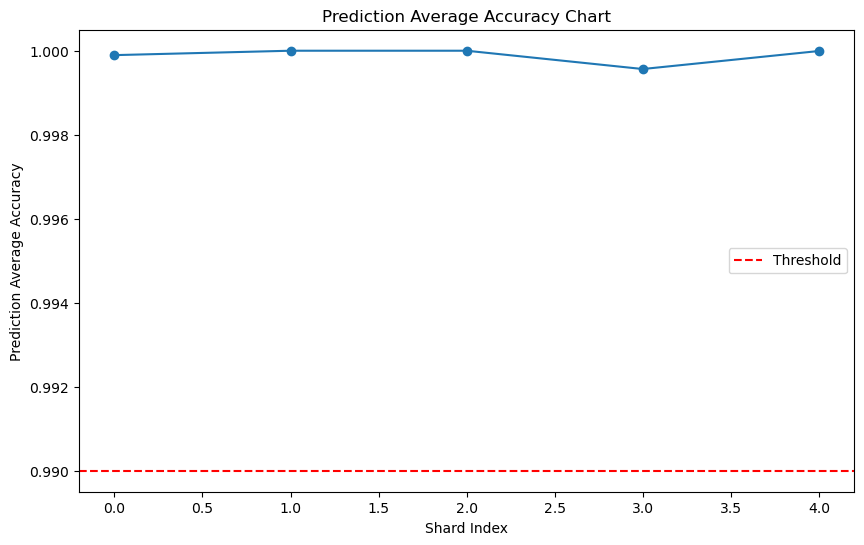

In [15]:
# Plotting the prediction average accuracy chart
plt.figure(figsize=(10, 6))
plt.plot(range(len(sharded_datasets)), prediction_average_accuracies, marker='o', linestyle='-')
plt.axhline(y=average_accuracy_threshold, color='r', linestyle='--', label='Threshold')

# Adding labels and title
plt.xlabel('Shard Index')
plt.ylabel('Prediction Average Accuracy')
plt.title('Prediction Average Accuracy Chart')

# Adding legend
plt.legend()

# Display the chart
plt.show()